In [1]:
import numpy as np
from numba import jit
import pints
import pints.plot
import pints_smol_jit as toy
import matplotlib.pyplot as plt



Select the desired model, true parameters and time array.

Then simulate to get synthetic data

In [2]:

model = toy.SmolModel(None,None)


true_parameters = [0.0004, 500]


times = np.linspace(0, 97, 9700)

org_values = model.simulate(true_parameters, times)

print(org_values)

print(org_values.shape)


Init 1
[[5.00000000e+002 0.00000000e+000 0.00000000e+000 ... 0.00000000e+000
  0.00000000e+000 0.00000000e+000]
 [4.99001395e+002 4.98554253e-001 4.98097899e-004 ... 4.35430388e-286
  4.39782144e-289 4.43609809e-292]
 [4.98005779e+002 9.94125808e-001 1.98447766e-003 ... 1.06595281e-258
  2.14300657e-261 4.30440349e-264]
 ...
 [4.36879537e+000 3.96042606e+000 3.59022903e+000 ... 3.85763559e-004
  3.56964840e-004 3.31154202e-004]
 [4.36797861e+000 3.95972382e+000 3.58962704e+000 ... 3.86061904e-004
  3.57244654e-004 3.31417218e-004]
 [4.36716209e+000 3.95902177e+000 3.58902520e+000 ... 3.86360415e-004
  3.57524627e-004 3.31680386e-004]]
(9700, 100)


Add noise to the data (using random sampling from normal distribution)

In [3]:

noise = 1
# values = org_values + noise * np.random.normal(0, 0.25, org_values.shape))
values = org_values *(1 + noise * np.random.normal(0, 1, org_values.shape))
# values = np.log(org_values) + noise * np.random.normal(0, 1, org_values.shape)
# values = np.exp(values)

size_noise = 100
noise_value = 25
# # Create a list with the specified size filled with a placeholder value
noise_arr = [noise_value for _ in range(size_noise)]


Set-up pints problem and log likelihoods

In [4]:

problem = pints.MultiOutputProblem(model, times, values)



log_likelihood = pints.GaussianLogLikelihood(problem)
# log_likelihood_2 = pints.GaussianIntegratedLogUniformLogLikelihood(problem)

print('Original problem dimension: ' + str(problem.n_parameters()))
print('New dimension: ' + str(log_likelihood.n_parameters()))
# print('New dimension: ' + str(log_likelihood_2.n_parameters()))

true_parameters += noise_arr
# # print(true_parameters)



Original problem dimension: 2
New dimension: 102


Create uniform log prior

In [5]:

# # Define the size of the list
size = 102
placeholder_lower_value = 1
placeholder_upper_value = 100
 
# # Create a list with the specified size filled with a placeholder value
prior_arr_lower = [placeholder_lower_value for _ in range(size)]
prior_arr_upper = [placeholder_upper_value for _ in range(size)]
prior_arr_lower[0] = 0.0001
prior_arr_upper[0] = 0.001
prior_arr_lower[1] = 100
prior_arr_upper[1] = 1000

# log_prior = pints.UniformLogPrior(
#     [0.000001, 1],
#     [0.01, 10000]
#     )
log_prior = pints.UniformLogPrior(
    prior_arr_lower,
    prior_arr_upper
    )

# Create a posterior log-likelihood (log(likelihood * prior))
# log_posterior = pints.LogPosterior(log_likelihood_2, log_prior)
log_posterior = pints.LogPosterior(log_likelihood, log_prior)


/var/folders/lt/9g_w308946v4x_5mqxc951qr0000gr/T/ipykernel_59381/4276937401.py:18: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  log_prior = pints.UniformLogPrior(


In [8]:

xs = [
    np.array(true_parameters) * 0.9,
    np.array(true_parameters) * 1.05,
    np.array(true_parameters) * 1.15,
]

chains = pints.mcmc_sample(log_posterior, 3, xs)

print(chains)

# xs = [
#     np.array(true_parameters) * 0.9,
#     np.array(true_parameters) * 1.05,
#     np.array(true_parameters) * 1.15,
# ]
# ITERS = 100
# mcmc = pints.MCMCController(log_posterior, 3, xs, method=pints.SliceDoublingMCMC)
# mcmc.set_max_iterations(ITERS)
# chains = mcmc.run()
# print(chains)



Using Haario-Bardenet adaptive covariance MCMC
Generating 3 chains.
Running in sequential mode.
Iter. Eval. Accept.   Accept.   Accept.   Time m:s
0     3      0         0         0          0:00.0
1     6      0         0         0          0:00.1
2     9      0         0         0          0:00.4
3     12     0         0         0          0:00.5
20    63     0         0.0476    0          0:01.5
40    123    0         0.0244    0          0:01.6
60    183    0.0164    0.0164    0          0:01.8
80    243    0.037     0.0123    0          0:02.0
100   303    0.0297    0.0297    0.0297     0:02.2
120   363    0.0331    0.0248    0.0331     0:02.4
140   423    0.0284    0.0213    0.0355     0:03.3
160   483    0.0248    0.0248    0.0373     0:03.7
180   543    0.0221    0.0221    0.0387     0:04.1
Initial phase completed.
200   603    0.0199    0.0249    0.039801   0:04.5
220   663    0.0452    0.0362    0.0588     0:05.3
240   723    0.0913    0.0581    0.0705     0:06.0
260   783   

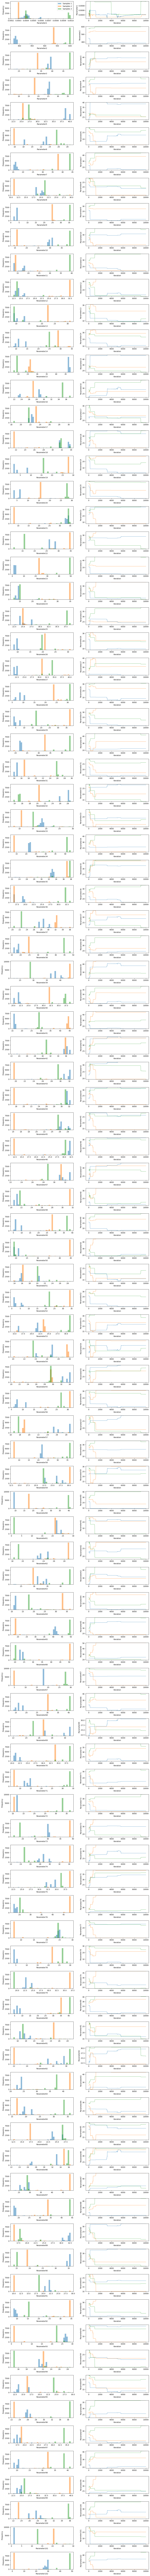

In [10]:

pints.plot.trace(chains)
plt.savefig("mcmc.png")
plt.show()